# Step 1: Stationarity and Seasonal Diagnostics for Net_demand

This notebook performs exploratory diagnostics only. It does **not** fit ARIMA/SARIMA/SARIMAX models, does not forecast, and does not use test data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")

[Data] Rows: 3471
[Data] Date range: 2013-03-02 to 2022-09-01
[Data] Inferred frequency: D
[Data] All daily steps: True
[Net_demand] Min: 28134.625
[Net_demand] Max: 83312.4166666667
[Net_demand] Mean: 49112.174691491404
[Net_demand] Std: 10697.628158540543
[Net_demand] Describe:
 count     3471.000000
mean     49112.174691
std      10697.628159
min      28134.625000
25%      40884.979167
50%      46326.895833
75%      56610.281250
max      83312.416667
Name: Net_demand, dtype: float64


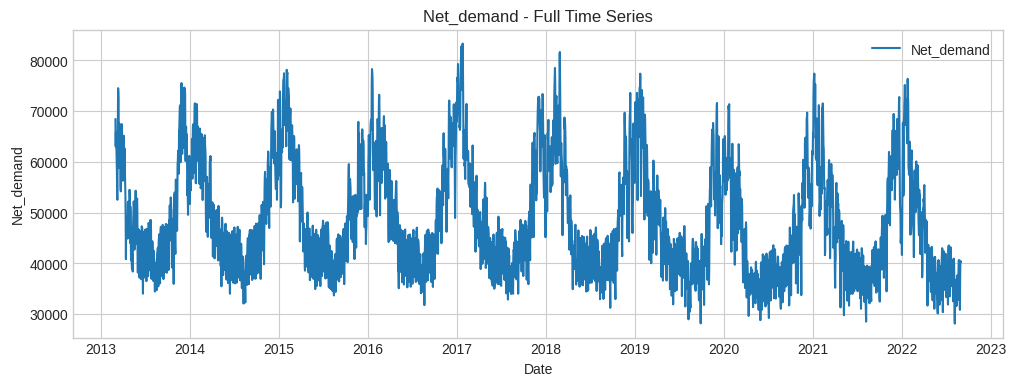

In [3]:
# 1. Load and prepare data
train_path = "../Data/train.csv"

train_df = pd.read_csv(train_path, parse_dates=["Date"])
train_df = train_df.sort_values("Date").reset_index(drop=True)

# Check date continuity (daily) and missing days
full_range = pd.date_range(train_df["Date"].min(), train_df["Date"].max(), freq="D")
missing_dates = full_range.difference(train_df["Date"])

print("[Data] Rows:", len(train_df))
print("[Data] Date range:", train_df["Date"].min().date(), "to", train_df["Date"].max().date())

# Set DateTimeIndex
train_df = train_df.set_index("Date")
train_df.index = pd.DatetimeIndex(train_df.index)

# Verify frequency
inferred_freq = pd.infer_freq(train_df.index)
all_daily = (train_df.index.to_series().diff().dropna() == pd.Timedelta(days=1)).all()
print("[Data] Inferred frequency:", inferred_freq)
print("[Data] All daily steps:", all_daily)

# Summary statistics for Net_demand
y = train_df["Net_demand"]
print("[Net_demand] Min:", y.min())
print("[Net_demand] Max:", y.max())
print("[Net_demand] Mean:", y.mean())
print("[Net_demand] Std:", y.std())
print("[Net_demand] Describe:\n", y.describe())

# Plot full time series
plt.figure(figsize=(12, 4))
plt.plot(y, label="Net_demand")
plt.title("Net_demand - Full Time Series")
plt.xlabel("Date")
plt.ylabel("Net_demand")
plt.legend()
plt.show()

[Rolling] Mean drift (last - first): -25726.657738095222
[Rolling] Std drift (last - first): 407.19604131985807


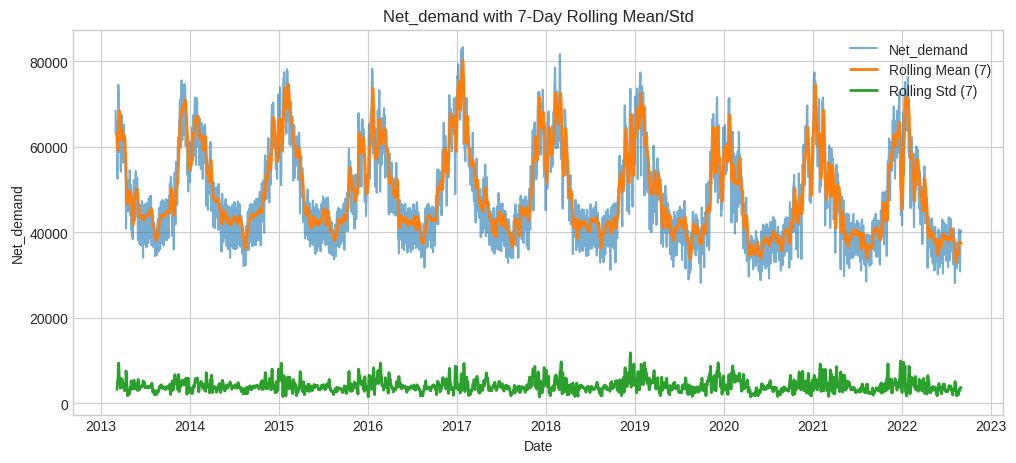

In [5]:
# 2. Visual stationarity inspection (rolling stats)
rolling_mean_7 = y.rolling(window=7).mean()
rolling_std_7 = y.rolling(window=7).std()

# Visual stationarity implies a roughly constant mean and variance over time.
# The plotted rolling mean/std and drift values below help interpret what we observe.
mean_drift = rolling_mean_7.dropna().iloc[-1] - rolling_mean_7.dropna().iloc[0]
std_drift = rolling_std_7.dropna().iloc[-1] - rolling_std_7.dropna().iloc[0]
print("[Rolling] Mean drift (last - first):", mean_drift)
print("[Rolling] Std drift (last - first):", std_drift)

plt.figure(figsize=(12, 5))
plt.plot(y, label="Net_demand", alpha=0.6)
plt.plot(rolling_mean_7, label="Rolling Mean (7)", linewidth=2)
plt.plot(rolling_std_7, label="Rolling Std (7)", linewidth=2)
plt.title("Net_demand with 7-Day Rolling Mean/Std")
plt.xlabel("Date")
plt.ylabel("Net_demand")
plt.legend()
plt.show()

In [6]:
# 3. Formal stationarity tests (ADF and KPSS)

def run_adf(series, name):
    # ADF null hypothesis: series has a unit root (non-stationary).
    result = adfuller(series.dropna(), autolag="AIC")
    output = {
        "test": "ADF",
        "series": name,
        "stat": result[0],
        "pvalue": result[1],
        "lags": result[2],
        "nobs": result[3],
    }
    print(f"[ADF] {name} | stat={output['stat']:.4f} | p={output['pvalue']:.4f} | lags={output['lags']} | n={output['nobs']}")
    # If p < 0.05, reject unit root => evidence of stationarity.
    return output


def run_kpss(series, name):
    # KPSS null hypothesis: series is level stationary.
    result = kpss(series.dropna(), regression="c", nlags="auto")
    output = {
        "test": "KPSS",
        "series": name,
        "stat": result[0],
        "pvalue": result[1],
        "lags": result[2],
    }
    print(f"[KPSS] {name} | stat={output['stat']:.4f} | p={output['pvalue']:.4f} | lags={output['lags']}")
    # If p < 0.05, reject stationarity => evidence of non-stationarity.
    return output

print("\n[Tests] Original series")
adf_orig = run_adf(y, "Net_demand")
kpss_orig = run_kpss(y, "Net_demand")

adf_orig_stationary = adf_orig["pvalue"] < 0.05
kpss_orig_stationary = kpss_orig["pvalue"] > 0.05

if adf_orig_stationary != kpss_orig_stationary:
    # Explicitly state conflict when ADF and KPSS disagree.
    print("[Tests] Conflict detected: ADF and KPSS lead to different conclusions on stationarity.")


[Tests] Original series
[ADF] Net_demand | stat=-4.4304 | p=0.0003 | lags=30 | n=3440
[KPSS] Net_demand | stat=0.4749 | p=0.0473 | lags=36
[Tests] Conflict detected: ADF and KPSS lead to different conclusions on stationarity.


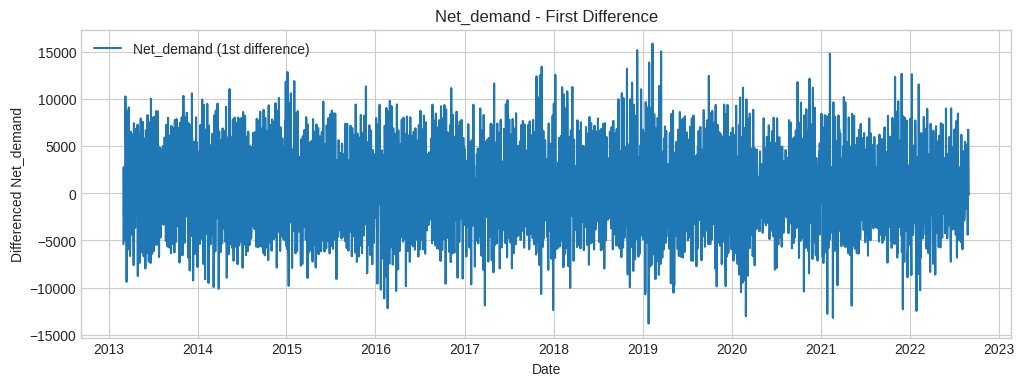


[Tests] First-differenced series
[ADF] Net_demand (diff 1) | stat=-11.8474 | p=0.0000 | lags=30 | n=3439
[KPSS] Net_demand (diff 1) | stat=0.0206 | p=0.1000 | lags=84


/tmp/ipykernel_33833/1376948708.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="c", nlags="auto")


In [7]:
# 4. Differencing analysis (first difference)
y_diff = y.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(y_diff, label="Net_demand (1st difference)")
plt.title("Net_demand - First Difference")
plt.xlabel("Date")
plt.ylabel("Differenced Net_demand")
plt.legend()
plt.show()

print("\n[Tests] First-differenced series")
adf_diff = run_adf(y_diff, "Net_demand (diff 1)")
kpss_diff = run_kpss(y_diff, "Net_demand (diff 1)")

adf_diff_stationary = adf_diff["pvalue"] < 0.05
kpss_diff_stationary = kpss_diff["pvalue"] > 0.05

if adf_diff_stationary != kpss_diff_stationary:
    print("[Tests] Conflict detected: ADF and KPSS disagree after differencing.")

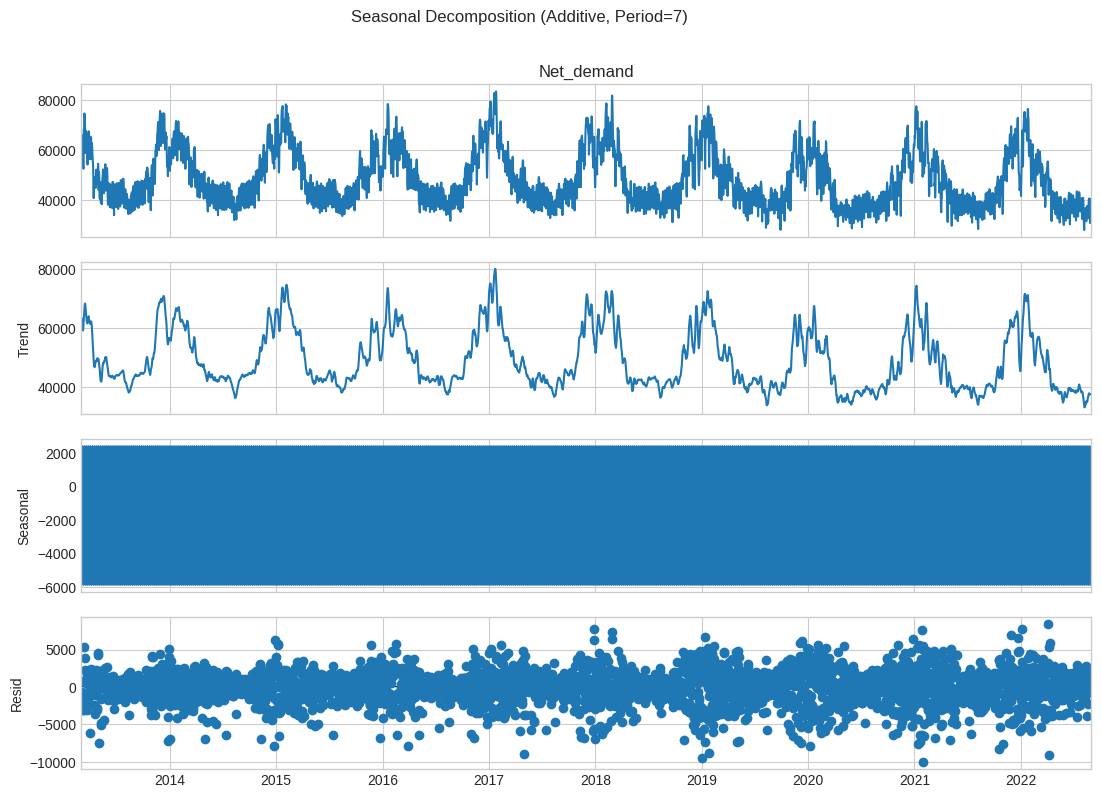

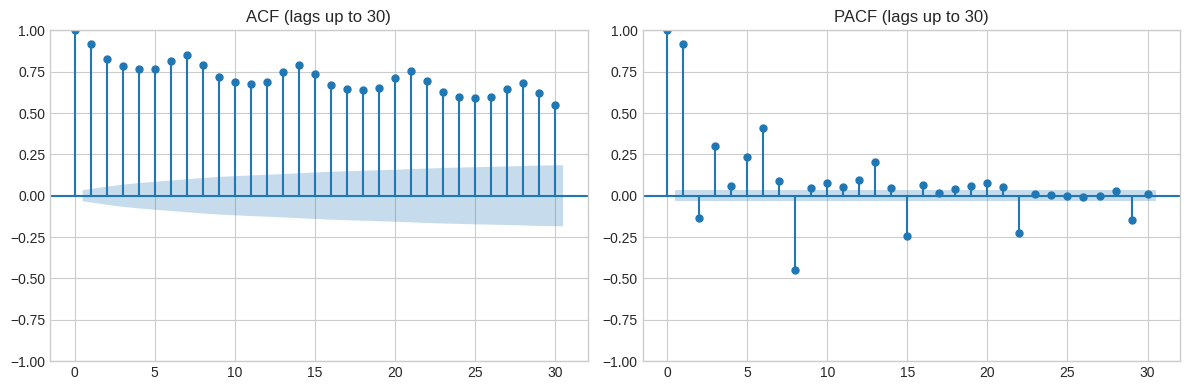

In [ ]:
# 5. Seasonal diagnostics (weekly period = 7)
# Seasonal decomposition (additive)
y_daily = y.asfreq("D")

y_daily_clean = y_daily.dropna()

decomp = seasonal_decompose(y_daily_clean, model="additive", period=7)
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Seasonal Decomposition (Additive, Period=7)", y=1.02)
plt.show()

# ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_daily_clean, lags=30, ax=axes[0])
plot_pacf(y_daily_clean, lags=30, ax=axes[1], method="ywm")
axes[0].set_title("ACF (lags up to 30)")
axes[1].set_title("PACF (lags up to 30)")
plt.tight_layout()
plt.show()

# Look for spikes at lags 7, 14, 21 and any slow decay patterns in ACF/PACF.

In [ ]:
# 5.bis stationarity checking with y_diff





In [9]:
# 6. Structured conclusion

def stationarity_label(adf_stationary, kpss_stationary):
    if adf_stationary and kpss_stationary:
        return "Stationary (both tests agree)"
    if (not adf_stationary) and (not kpss_stationary):
        return "Non-stationary (both tests agree)"
    return "Inconclusive (tests conflict)"

orig_label = stationarity_label(adf_orig_stationary, kpss_orig_stationary)
diff_label = stationarity_label(adf_diff_stationary, kpss_diff_stationary)

# Differencing recommendation (d) should be based on both visual inspection and tests.
if orig_label.startswith("Non-stationary") and diff_label.startswith("Stationary"):
    d_candidate = "1 (first difference likely helps)"
elif orig_label.startswith("Stationary"):
    d_candidate = "0 (no differencing suggested)"
else:
    d_candidate = "Undetermined (inspect plots and test conflicts)"

print("\n" + "=" * 60)
print("DIAGNOSTIC SUMMARY")
print("=" * 60)
print("Is the series stationary?", orig_label)
print("Is first differencing required?", "Likely" if "1" in d_candidate else "Possibly not" if "0" in d_candidate else "Unclear")
print("Is weekly seasonality visible?", "Inspect decomposition/ACF/PACF for lag-7 spikes")
print("Candidate value for d:", d_candidate)
print("Candidate seasonal period:", "7 (daily data, weekly pattern check)")
print("=" * 60)

# Note: This step is diagnostic only. Do not fit ARIMA/SARIMA models here.


DIAGNOSTIC SUMMARY
Is the series stationary? Inconclusive (tests conflict)
Is first differencing required? Unclear
Is weekly seasonality visible? Inspect decomposition/ACF/PACF for lag-7 spikes
Candidate value for d: Undetermined (inspect plots and test conflicts)
Candidate seasonal period: 7 (daily data, weekly pattern check)
